In [1]:
# install needed libraries
import pandas as pd
import matplotlib.pyplot as plt
import pulp
import numpy as np

In [3]:
# loading saved variables
import dill
dill.load_session("session.dill")

In [5]:
# Read the excel
file_path = r"D:\datasets\EPNL\Prices Case Power Plant Optimization.xlsx"
df = pd.read_excel(file_path)
df.head()

,Unnamed: 0,Unnamed: 1,Simulation 1,Unnamed: 3,Unnamed: 4,Unnamed: 5,Simulation 2,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 11,Unnamed: 12,Unnamed: 13,Simulation 4,Unnamed: 15,Unnamed: 16,Unnamed: 17,Simulation 5,Unnamed: 19,Unnamed: 20
0,NaT,NaN,Power,Gas,CO2,NaN,Power,Gas,CO2,NaN,...,Gas,CO2,NaN,Power,Gas,Co2Sim4,NaN,Power,Gas,CO2
1,2022-01-01 00:00:00,NaN,215.88,96.3,88.09,NaN,170.38,110.05,88.28,NaN,...,120.1,90.38,NaN,174.39,102.46,91.38,NaN,161.94,96.02,87.86
2,2022-01-01 01:00:00,NaN,160.48,96.3,88.09,NaN,154.68,110.05,88.28,NaN,...,120.1,90.38,NaN,158.24,102.46,91.38,NaN,154.53,96.02,87.86
3,2022-01-01 02:00:00,NaN,154,96.3,88.09,NaN,151.21,110.05,88.28,NaN,...,120.1,90.38,NaN,154.26,102.46,91.38,NaN,154.83,96.02,87.86
4,2022-01-01 03:00:00,NaN,152.35,96.3,88.09,NaN,143.55,110.05,88.28,NaN,...,120.1,90.38,NaN,156.05,102.46,91.38,NaN,133.27,96.02,87.86


In [7]:
# Build dict of simulation dataframes
df = df.rename(columns={df.columns[0]: "time"})

header_like_row = df.iloc[0]
df["time"] = pd.to_datetime(df["time"], errors="coerce")
df = df.dropna(subset=["time"]).reset_index(drop=True)

# The "Power" labels in the header row tell us which columns are power columns
power_col_indices = [i for i, val in enumerate(header_like_row) if str(val).strip().lower() == "power"]

# Build dict of simulation dfs
sim_dfs = {}

for sim, power_idx in enumerate(power_col_indices, start=1):
    gas_idx = power_idx + 1
    co2_idx = power_idx + 2

    power_col = df.columns[power_idx]
    gas_col   = df.columns[gas_idx]
    co2_col   = df.columns[co2_idx]

    sim_df = df[["time", power_col, gas_col, co2_col]].copy()
    sim_df.columns = ["time", "power_price", "gas_price", "co2_price"]

    sim_dfs[sim] = sim_df

In [9]:
# check if correct
sim_dfs[3].head()

,time,power_price,gas_price,co2_price
0,2022-01-01 00:00:00,175.91,120.1,90.38
1,2022-01-01 01:00:00,159.36,120.1,90.38
2,2022-01-01 02:00:00,158.59,120.1,90.38
3,2022-01-01 03:00:00,248.39,120.1,90.38
4,2022-01-01 04:00:00,158.94,120.1,90.38


In [11]:
# make sure theyre numeric
for sim, df_sim in sim_dfs.items():
    for col in ["power_price", "gas_price", "co2_price"]:
        df_sim[col] = pd.to_numeric(df_sim[col], errors="coerce")

In [13]:
# re-usable function to plot the simulated timeseries
def plot_simulations(sim_dfs, y_col, title, y_label):
    plt.figure(figsize=(16,4))
    for sim, df_sim in sim_dfs.items():
        plt.plot(df_sim["time"], df_sim[y_col], label=f"Simulation {sim}")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(y_label)
    plt.legend(loc='upper left')
    plt.show()

In [15]:
# re-usable function for descriptive stats
def descriptive_stats_per_sim(sim_dfs, cols=("power_price", "gas_price", "co2_price")):
    stats = {}

    for sim, df_sim in sim_dfs.items():
        stats[sim] = df_sim[list(cols)].describe().T

    return stats

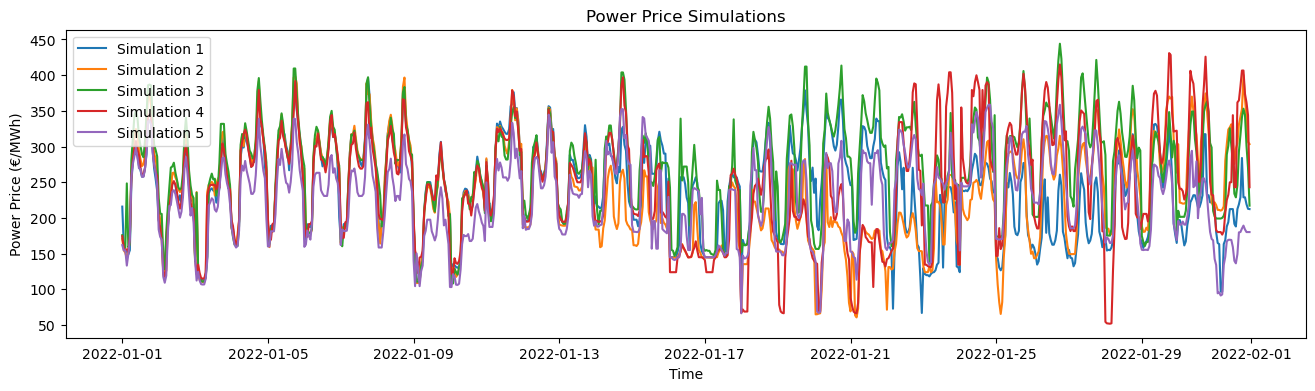

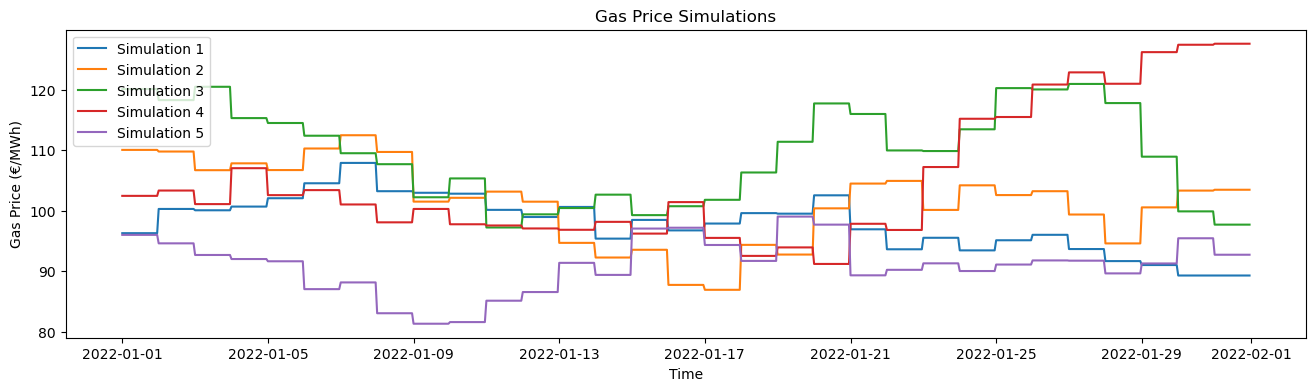

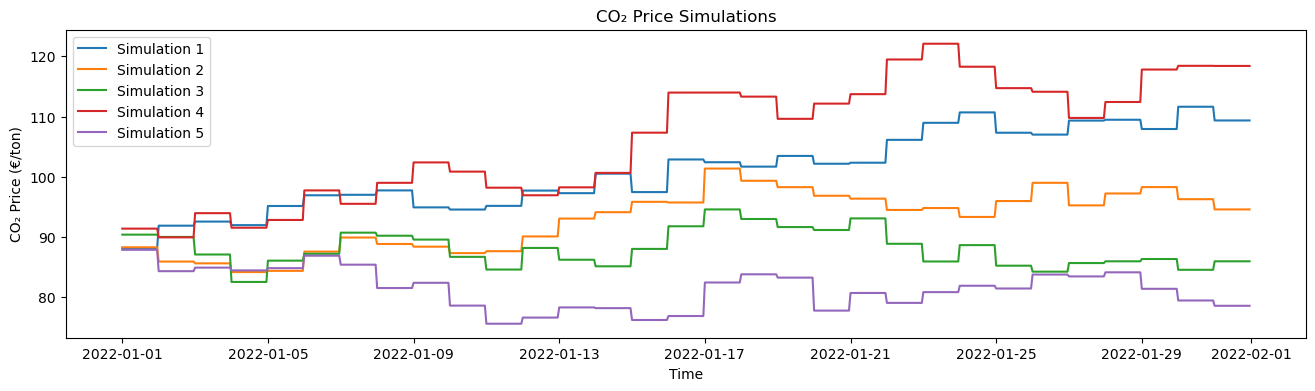

In [17]:
plot_simulations(sim_dfs, "power_price", "Power Price Simulations", "Power Price (€/MWh)")
plot_simulations(sim_dfs, "gas_price",   "Gas Price Simulations",   "Gas Price (€/MWh)")
plot_simulations(sim_dfs, "co2_price",   "CO₂ Price Simulations",   "CO₂ Price (€/ton)")

In [19]:
stats = descriptive_stats_per_sim(sim_dfs)

# stats for a single simulation to get intuition
stats[1]

,count,mean,std,min,25%,50%,75%,max
power_price,744.0,238.174745,63.125196,66.87,188.225,243.12,286.3775,395.74
gas_price,744.0,97.956129,4.460023,89.31,95.130,98.49,100.6900,107.90
co2_price,744.0,101.016774,6.424145,88.09,95.160,101.68,107.3100,111.63


In [21]:
def optimize_ccgt_bucket_expected(sim_dfs,
                                  P_MIN=220.0, P_MAX=400.0,
                                  MAX_STARTS=15, MAX_RUN_HOURS=250,
                                  EFF_MIN=0.45, EFF_MAX=0.50,
                                  CO2_PER_MWH_GAS=0.2,
                                  START=None,
                                  time_limit=120,
                                  init_running=True,
                                  scenario_weights=None):
    """
    Optimizes the running schedule based on the scenario-average expected objective whilst respecting the contraints.
    """
    if START is None:
        START = {
            1: {"pwr": 75.0,  "gas": 190.0, "co2": 35.0},
            2: {"pwr": 190.0, "gas": 700.0, "co2": 130.0},
            3: {"pwr": 210.0, "gas": 800.0, "co2": 150.0},
        }

    # Make lists
    dfs = list(sim_dfs.values()) if isinstance(sim_dfs, dict) else list(sim_dfs)
    if len(dfs) == 0:
        raise ValueError("sim_dfs is empty")

    S = len(dfs)
    T = len(dfs[0].reset_index(drop=True))

    # Check if simulations are same length
    for i, dfi in enumerate(dfs):
        dfi = dfi.reset_index(drop=True)
        if len(dfi) != T:
            raise ValueError(f"Scenario {i} has length {len(dfi)} but expected {T}")

    # weights in case one scenario needs to weigh more than the other
    if scenario_weights is None:
        w = [1.0 / S] * S
    else:
        if len(scenario_weights) != S:
            raise ValueError("scenario_weights must have same length as sim_dfs")
        wsum = float(sum(scenario_weights))
        if wsum <= 0:
            raise ValueError("scenario_weights must sum to a positive value")
        w = [float(x) / wsum for x in scenario_weights]  # normalize to sum to 1

    # time normalisation
    base = dfs[0].reset_index(drop=True)
    time_col = base["time"].copy()

    # expected prices just for reporting
    pow_mat = pd.concat([d.reset_index(drop=True)["power_price"] for d in dfs], axis=1).astype(float)
    gas_mat = pd.concat([d.reset_index(drop=True)["gas_price"]   for d in dfs], axis=1).astype(float)
    co2_mat = pd.concat([d.reset_index(drop=True)["co2_price"]   for d in dfs], axis=1).astype(float)
    power_exp = pow_mat.mean(axis=1).tolist()
    gas_exp   = gas_mat.mean(axis=1).tolist()
    co2_exp   = co2_mat.mean(axis=1).tolist()

    # Linear approximation of fuel used at different power, in case we want another fuel curve (Will also end up at 0, 220 or 400 so sufficient now)
    HR_MIN = 1.0 / EFF_MIN
    HR_MAX = 1.0 / EFF_MAX
    FUEL_AT_PMIN = HR_MIN * P_MIN
    FUEL_AT_PMAX = HR_MAX * P_MAX
    m = (FUEL_AT_PMAX - FUEL_AT_PMIN) / (P_MAX - P_MIN)
    c = FUEL_AT_PMIN - m * P_MIN

    model = pulp.LpProblem("CCGT_Optimization_StateBuckets_Expected", pulp.LpMaximize)
    # INTRODUCING THE VARIABLES
    # Core decisions, which are shared across scenarios
    on    = pulp.LpVariable.dicts("on",    range(T), 0, 1, cat="Binary")
    p     = pulp.LpVariable.dicts("p",     range(T), 0, P_MAX, cat="Continuous")
    start = pulp.LpVariable.dicts("start", range(T), 0, 1, cat="Binary")
    shut  = pulp.LpVariable.dicts("shut",  range(T), 0, 1, cat="Binary")

    # Off-duration states trackers
    off_h = {(t, h): pulp.LpVariable(f"off_{h}_{t}", 0, 1, cat="Binary")
             for t in range(T) for h in range(1, 36)}
    off36 = pulp.LpVariable.dicts("off36", range(T), 0, 1, cat="Binary")

    # Start types
    stype = {(t, k): pulp.LpVariable(f"stype_{t}_{k}", 0, 1, cat="Binary")
             for t in range(T) for k in [1, 2, 3]}

    # RESTRICTIONS
    # init_running is the state at the end of Dec 31 (t=-1):
    on_init = 1 if init_running else 0

    # INITIAL STATE RESTRICTIONS
    # start[0] = 1 iff (on_init=0 and on[0]=1)
    model += start[0] >= on[0] - on_init, "start0_lb"
    model += start[0] <= on[0],           "start0_ub_on"
    model += start[0] <= 1 - on_init,     "start0_ub_init"

    # shut[0] = 1 iff (on_init=1 and on[0]=0)
    model += shut[0] >= on_init - on[0],  "shut0_lb"
    model += shut[0] <= on_init,          "shut0_ub_init"
    model += shut[0] <= 1 - on[0],        "shut0_ub_off"

    # No start type at t=0 so we dont have start up costs
    model += stype[(0,1)] + stype[(0,2)] + stype[(0,3)] == 0, "stype0_zero"

    # off-states at t=0.
    if on_init == 1:
        model += off_h[(0,1)] == shut[0], "initial_off1_from_shut0"
        model += pulp.lpSum(off_h[(0,h)] for h in range(2, 36)) + off36[0] == 0, "initial_other_off_zero"
    else:
        model += off_h[(0,1)] == 1 - on[0], "initial_off1_if_off"
        model += pulp.lpSum(off_h[(0,h)] for h in range(2, 36)) + off36[0] == 0, "initial_other_off_zero"

    # GENERAL RESTRICTIONS
    # Generation limits
    for t in range(T):
        model += p[t] <= P_MAX * on[t], f"p_max_if_on_{t}"
        model += p[t] >= P_MIN * on[t], f"p_min_if_on_{t}"
        
    # Can only be a specific amount of hours off or be on
    for t in range(T):
        model += on[t] + pulp.lpSum(off_h[(t, h)] for h in range(1, 36)) + off36[t] == 1, f"onehot_{t}"

    # Tracking starts and shutdowns
    for t in range(1, T):
        model += start[t] >= on[t] - on[t-1], f"start_lb_{t}"
        model += start[t] <= 1 - on[t-1],     f"start_ub1_{t}"
        model += start[t] <= on[t],           f"start_ub2_{t}"

        model += shut[t] >= on[t-1] - on[t],  f"shut_lb_{t}"
        model += shut[t] <= on[t-1],          f"shut_ub1_{t}"
        model += shut[t] <= 1 - on[t],        f"shut_ub2_{t}"

    # Run hours and starts restrictions
    model += pulp.lpSum(on[t] for t in range(T))    <= MAX_RUN_HOURS, "run_hours_limit"
    model += pulp.lpSum(start[t] for t in range(T)) <= MAX_STARTS,    "starts_limit"

    # Off state transition restrictions
    for t in range(1, T):
        model += off_h[(t, 1)] == shut[t], f"off1_equals_shutdown_{t}"

    for t in range(1, T):
        for h in range(2, 36):
            model += off_h[(t, h)] <= off_h[(t-1, h-1)],         f"off_adv_ub_prev_{t}_{h}"
            model += off_h[(t, h)] <= 1 - on[t],                 f"off_adv_ub_off_{t}_{h}"
            model += off_h[(t, h)] >= off_h[(t-1, h-1)] - on[t], f"off_adv_lb_{t}_{h}"

    for t in range(1, T):
        model += off36[t] <= 1 - on[t], f"off36_offonly_{t}"
        model += off36[t] <= off_h[(t-1, 35)] + off36[t-1], f"off36_ub_prev_{t}"
        model += off36[t] >= off_h[(t-1, 35)] - on[t],      f"off36_lb_from35_{t}"
        model += off36[t] >= off36[t-1] - on[t],            f"off36_lb_from36_{t}"

    # Start type based on number of hours off in t-1
    for t in range(T):
        model += stype[(t,1)] + stype[(t,2)] + stype[(t,3)] == start[t], f"stype_sum_{t}"

    for t in range(1, T):
        off_1_10  = pulp.lpSum(off_h[(t-1, h)] for h in range(1, 11))
        off_11_35 = pulp.lpSum(off_h[(t-1, h)] for h in range(11, 36))

        model += stype[(t,1)] <= off_1_10,   f"stype1_allowed_{t}"
        model += stype[(t,2)] <= off_11_35,  f"stype2_allowed_{t}"
        model += stype[(t,3)] <= off36[t-1], f"stype3_allowed_{t}"

    # No start type at t=0 so we dont have start up costs
    model += stype[(0,1)] + stype[(0,2)] + stype[(0,3)] == 0, "stype0_zero_repeat"

    # OBJECTIVE
    # expected profit across scenarios
    profit_terms = []

    for s, df_s in enumerate(dfs):
        df_s = df_s.reset_index(drop=True)
        power_s = df_s["power_price"].astype(float).tolist()
        gas_s   = df_s["gas_price"].astype(float).tolist()
        co2_s   = df_s["co2_price"].astype(float).tolist()
        ws = w[s]

        # Operating hours profit
        for t in range(T):
            fuel_t = m * p[t] + c * on[t]
            profit_terms.append(ws * (power_s[t] * p[t]))
            profit_terms.append(ws * (-gas_s[t] * fuel_t))
            profit_terms.append(ws * (-co2_s[t] * (CO2_PER_MWH_GAS * fuel_t)))

        # Startup profit
        for t in range(1, T):
            for k in [1, 2, 3]:
                profit_terms.append(
                    ws * stype[(t,k)] * (
                        power_s[t-1] * START[k]["pwr"]
                        - gas_s[t-1]  * START[k]["gas"]
                        - co2_s[t-1]  * START[k]["co2"]
                    )
                )

    model += pulp.lpSum(profit_terms)

    # Solve MILP
    solver = pulp.PULP_CBC_CMD(msg=True, timeLimit=time_limit)
    status = model.solve(solver)

    # Extract results
    out = pd.DataFrame({
        "time": time_col,
        "power_price": power_exp,
        "gas_price": gas_exp,
        "co2_price": co2_exp,
    })

    out["on"]    = [int(pulp.value(on[t]) > 0.5) for t in range(T)]
    out["p_mw"]  = [float(pulp.value(p[t]) or 0.0) for t in range(T)]
    out["start"] = [int(pulp.value(start[t]) > 0.5) for t in range(T)]

    # Reconstruct off-hours because now they were binary
    off_hours = []
    for t in range(T):
        if out.loc[t, "on"] == 1:
            off_hours.append(0.0)
        else:
            hh = 0
            for h in range(1, 36):
                v = pulp.value(off_h[(t, h)])
                if v is not None and v > 0.5:
                    hh = h
                    break
            if hh == 0:
                v36 = pulp.value(off36[t])
                if v36 is not None and v36 > 0.5:
                    hh = 36
            off_hours.append(float(hh))
    out["off_hours"] = off_hours

    # To analyse which start types are being used
    stype_real = []
    for t in range(T):
        if out.loc[t, "start"] == 0:
            stype_real.append(0)
        else:
            chosen = 0
            for k in [1, 2, 3]:
                v = pulp.value(stype[(t, k)])
                if v is not None and v > 0.5:
                    chosen = k
                    break
            stype_real.append(chosen)
    out["start_type"] = stype_real

    out["fuel_mwh_gas"] = m * out["p_mw"] + c * out["on"]
    out["co2_tons"] = CO2_PER_MWH_GAS * out["fuel_mwh_gas"]

    print("Status:", pulp.LpStatus[status])
    print("Objective (expected profit):", pulp.value(model.objective))
    print("Total running hours:", int(out["on"].sum()))
    print("Total starts:", int(out["start"].sum()))

    return model, out

In [25]:
# Solve model with max 15 start and 250 running hours given the simulated prices
modelE, outE = optimize_ccgt_bucket_expected(
    sim_dfs,
    MAX_STARTS=15,
    MAX_RUN_HOURS=250,
    time_limit=3600,
    init_running=True
)

Status: Optimal
Objective (expected profit): 5405668.931111108
Total running hours: 250
Total starts: 15


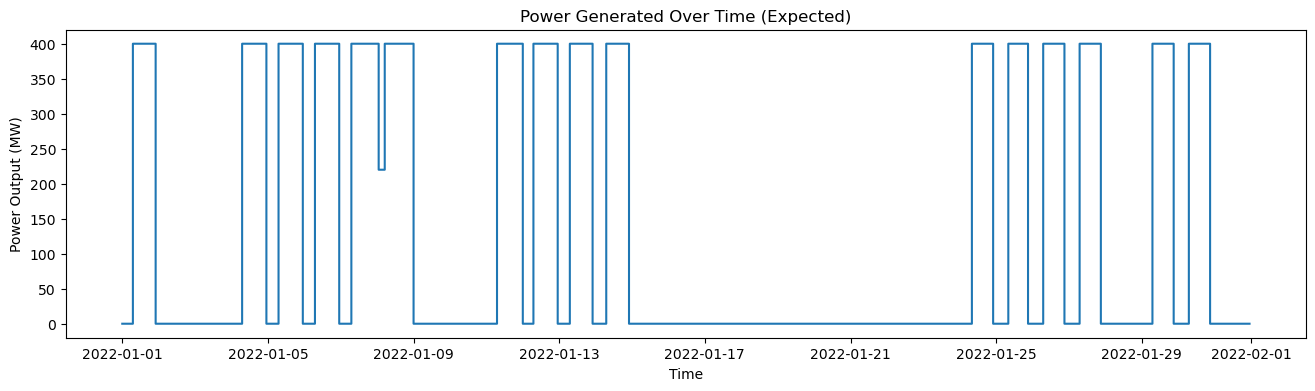

In [26]:
plt.figure(figsize=(16, 4))
plt.step(outE["time"], outE["p_mw"], where="post")
plt.title("Power Generated Over Time (Expected)")
plt.xlabel("Time")
plt.ylabel("Power Output (MW)")
plt.show()

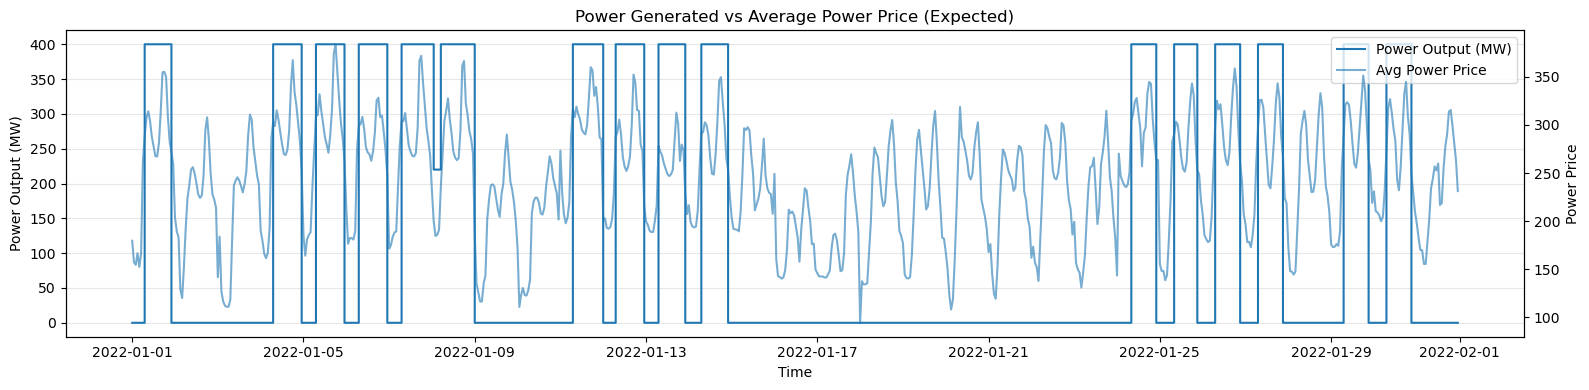

In [27]:
# Plot power generated vs average power price
fig, ax1 = plt.subplots(figsize=(16, 4))

ax1.step(outE["time"], outE["p_mw"], where="post", label="Power Output (MW)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Power Output (MW)")
ax1.grid(True, axis="y", alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(outE["time"], outE["power_price"], alpha=0.6, label="Avg Power Price")
ax2.set_ylabel("Power Price")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.title("Power Generated vs Average Power Price (Expected)")
plt.tight_layout()
plt.show()

In [118]:
# Solve model with an extra running hour
modelEExtraHour, outEExtraHour = optimize_ccgt_bucket_expected(
    sim_dfs,              # list or dict of scenario dfs
    MAX_STARTS=15,
    MAX_RUN_HOURS=251,
    time_limit=3600,
    init_running=True
)

Status: Optimal
Objective (expected profit): 5416350.851111108
Total running hours: 251
Total starts: 15


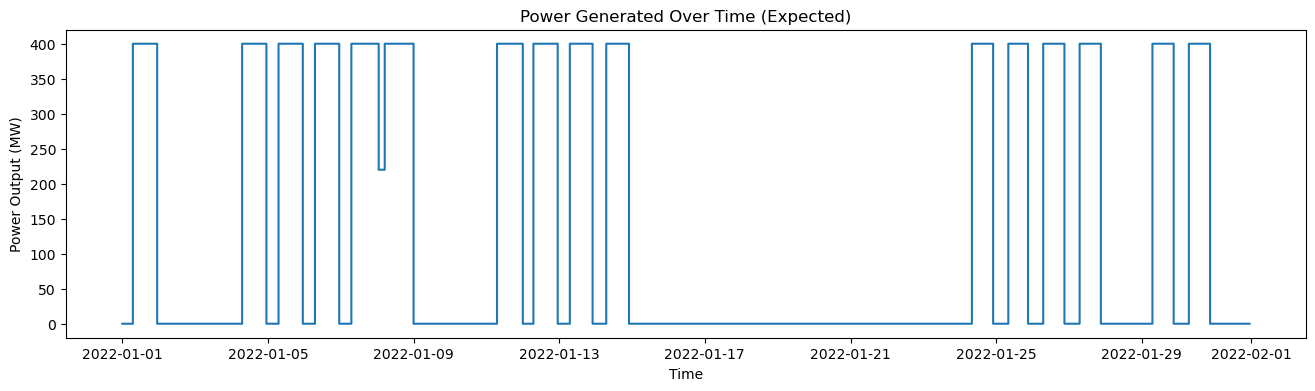

In [122]:
plt.figure(figsize=(16, 4))
plt.step(outEExtraHour["time"], outEExtraHour["p_mw"], where="post")
plt.title("Power Generated Over Time (Expected)")
plt.xlabel("Time")
plt.ylabel("Power Output (MW)")
plt.show()

In [31]:
# Solve model with an extra start
modelEExtraStart, outEExtraStart = optimize_ccgt_bucket_expected(
    sim_dfs,              # list or dict of scenario dfs
    MAX_STARTS=16,
    MAX_RUN_HOURS=250,
    time_limit=3600,
    init_running=True
)

Status: Optimal
Objective (expected profit): 5527640.920000004
Total running hours: 250
Total starts: 16


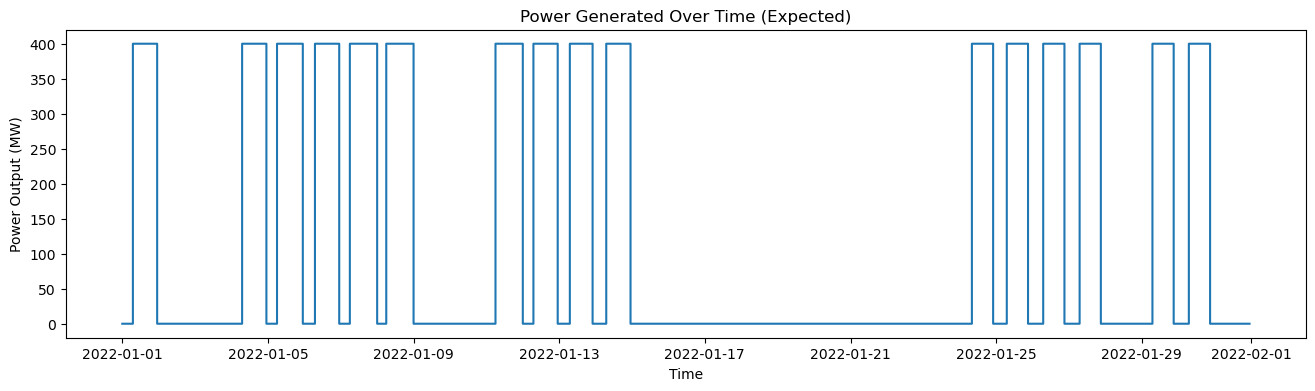

In [32]:
plt.figure(figsize=(16, 4))
plt.step(outEExtraStart["time"], outEExtraStart["p_mw"], where="post")
plt.title("Power Generated Over Time (Expected)")
plt.xlabel("Time")
plt.ylabel("Power Output (MW)")
plt.show()

In [28]:
def fuel_line_params(P_MIN=220.0, P_MAX=400.0, EFF_MIN=0.45, EFF_MAX=0.50):
    HR_MIN = 1.0 / EFF_MIN
    HR_MAX = 1.0 / EFF_MAX
    FUEL_AT_PMIN = HR_MIN * P_MIN
    FUEL_AT_PMAX = HR_MAX * P_MAX
    m = (FUEL_AT_PMAX - FUEL_AT_PMIN) / (P_MAX - P_MIN)
    c = FUEL_AT_PMIN - m * P_MIN
    return m, c

In [29]:
m, c = fuel_line_params(P_MIN=220, P_MAX=400, EFF_MIN=0.45, EFF_MAX=0.50)
START = {
    1: {"pwr": 75.0,  "gas": 190.0, "co2": 35.0},
    2: {"pwr": 190.0, "gas": 700.0, "co2": 130.0},
    3: {"pwr": 210.0, "gas": 800.0, "co2": 150.0},
}

In [33]:
# Re-usable function to analyse a operation pattern for a given window
def expected_profit_window_stats(out_schedule, sim_dfs, m, c, START,
                                 CO2_PER_MWH_GAS=0.2,
                                 start_time=None, end_time=None,
                                 scenario_weights=None,
                                 var_level=5):
    """
    Evaluate a fixed schedule over a time window and return:
      - profit per scenario
      - expected (weighted) profit
      - mean/median/std/min/max
      - VaR / CVaR
      - run vs startup profit breakdowns
      - hours run and starts used in the window
    """
    # normalize scenarios
    dfs = list(sim_dfs.values()) if isinstance(sim_dfs, dict) else list(sim_dfs)
    S = len(dfs)
    if S == 0:
        raise ValueError("sim_dfs is empty")

    if scenario_weights is None:
        w = np.ones(S) / S
    else:
        w = np.array(scenario_weights, dtype=float)
        if len(w) != S:
            raise ValueError("scenario_weights must have same length as sim_dfs")
        if w.sum() <= 0:
            raise ValueError("scenario_weights must sum to a positive value")
        w = w / w.sum()

    # window mask
    sched_time = pd.to_datetime(out_schedule["time"])
    mask = np.ones(len(out_schedule), dtype=bool)
    if start_time is not None:
        mask &= (sched_time >= pd.to_datetime(start_time)).to_numpy()
    if end_time is not None:
        mask &= (sched_time < pd.to_datetime(end_time)).to_numpy()

    # schedule decisions
    on = out_schedule["on"].to_numpy(dtype=float)
    p  = out_schedule["p_mw"].to_numpy(dtype=float)
    st = out_schedule["start_type"].to_numpy(dtype=int)
    start_bin = (st > 0).astype(float)

    hours_run = int(on[mask].sum())
    starts_used = int(start_bin[mask].sum())

    fuel = m * p + c * on
    co2_tons = CO2_PER_MWH_GAS * fuel

    profits = np.zeros(S, dtype=float)
    run_profits = np.zeros(S, dtype=float)
    startup_profits = np.zeros(S, dtype=float)

    # time alignment
    sched_time_set = set(sched_time)

    for s, df_s in enumerate(dfs):
        df_s = df_s.reset_index(drop=True).copy()

        # align scenario rows to schedule times.
        if "time" in df_s.columns:
            df_s["time"] = pd.to_datetime(df_s["time"])
            aligned = df_s[df_s["time"].isin(sched_time_set)].sort_values("time").reset_index(drop=True)

            if len(aligned) == len(out_schedule):
                df_use = aligned
            else:
                # fallback: same ordering/horizon assumption (Wat in deze case al het geval is)
                df_use = df_s.iloc[:len(out_schedule)].reset_index(drop=True)
        else:
            df_use = df_s.iloc[:len(out_schedule)].reset_index(drop=True)

        # sanity check
        if len(df_use) != len(out_schedule):
            raise ValueError(
                f"Scenario {s}: length {len(df_use)} after alignment/slicing "
                f"does not match schedule length {len(out_schedule)}."
            )

        power = df_use["power_price"].astype(float).to_numpy()
        gas   = df_use["gas_price"].astype(float).to_numpy()
        co2p  = df_use["co2_price"].astype(float).to_numpy()

        run_profit = power * p - gas * fuel - co2p * co2_tons

        startup_profit = np.zeros_like(run_profit)
        for t in range(1, len(run_profit)):
            k = st[t]
            if k in (1, 2, 3):
                startup_profit[t] = (
                    power[t-1] * START[k]["pwr"]
                    - gas[t-1]  * START[k]["gas"]
                    - co2p[t-1] * START[k]["co2"]
                )

        total = run_profit + startup_profit

        run_profits[s] = float(run_profit[mask].sum())
        startup_profits[s] = float(startup_profit[mask].sum())
        profits[s] = float(total[mask].sum())

    expected_profit = float(np.dot(w, profits))

    # risk stats (voor als we meer simulaties hebben)
    q = float(np.percentile(profits, var_level))
    cvar = float(profits[profits <= q].mean()) if np.any(profits <= q) else q

    return {
        "profits_per_scenario": profits,
        "run_profit_per_scenario": run_profits,
        "startup_profit_per_scenario": startup_profits,

        "expected_profit": expected_profit,
        "mean_profit": float(profits.mean()),
        "median_profit": float(np.median(profits)),
        "std_profit": float(profits.std()),
        "min_profit": float(profits.min()),
        "max_profit": float(profits.max()),
        f"VaR_{var_level}pct": q,
        f"CVaR_{var_level}pct": cvar,

        "hours_run": hours_run,
        "starts_used": starts_used,

        "window_start": pd.to_datetime(start_time) if start_time is not None else None,
        "window_end": pd.to_datetime(end_time) if end_time is not None else None,
        "window_hours": int(mask.sum()),
    }

In [51]:
# stats of januari
stats_w = expected_profit_window_stats(
    outE, sim_dfs, m, c, START,
    start_time="2022-01-01 00:00:00",
    end_time="2022-02-01 00:00:00"
)

print("Expected profit:", stats_w["expected_profit"])
print("Std:", stats_w["std_profit"])
print("Worst case:", stats_w["min_profit"])
print("Hours run:", stats_w["hours_run"])
print("Starts used:", stats_w["starts_used"])

Expected profit: 5405668.931111111
Std: 753804.1435719099
Worst case: 4153534.211111111
Hours run: 250
Starts used: 15


In [32]:
# We see that there is a big gap from januari 15 to januari 24, if maintenance can be done during that time, what happens to our profit
# from januari 1 to januari 15 if we allocate all our resources there?

In [49]:
# stats of first half of januari with normal model
stats_w = expected_profit_window_stats(
    outE, sim_dfs, m, c, START,
    start_time="2022-01-01 00:00:00",
    end_time="2022-01-16 00:00:00"
)

print("Expected profit:", stats_w["expected_profit"])
print("Std:", stats_w["std_profit"])
print("Worst case:", stats_w["min_profit"])
print("Hours run:", stats_w["hours_run"])
print("Starts used:", stats_w["starts_used"])

Expected profit: 3793399.071111111
Std: 225306.15216208302
Worst case: 3371787.85
Hours run: 167
Starts used: 9


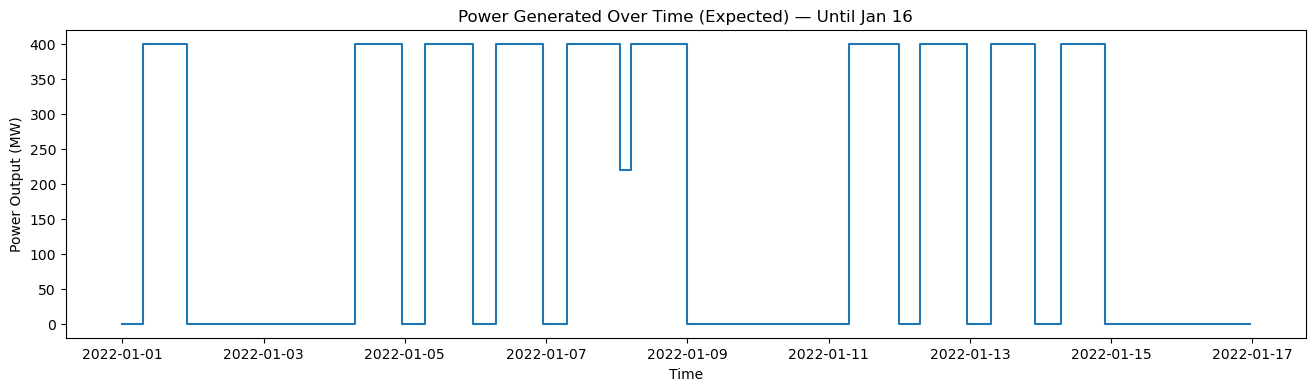

In [57]:
# schedule of first half of januari with normal model
end_time = pd.to_datetime("2022-01-16 23:00:00")

mask = pd.to_datetime(outE["time"]) <= end_time
outE_16 = outE.loc[mask]

plt.figure(figsize=(16, 4))
plt.step(outE_16["time"], outE_16["p_mw"], where="post")
plt.title("Power Generated Over Time (Expected) — Until Jan 16")
plt.xlabel("Time")
plt.ylabel("Power Output (MW)")
plt.show()

In [45]:
# function to slice dataframes so we can train the model on a slice
def slice_sim_dfs_until(sim_dfs, end_time):
    """
    Slice all scenario dataframes up to end_time.
    """
    end_time = pd.to_datetime(end_time)

    if isinstance(sim_dfs, dict):
        return {
            k: df[pd.to_datetime(df["time"]) <= end_time].reset_index(drop=True)
            for k, df in sim_dfs.items()
        }
    else:  # list
        return [
            df[pd.to_datetime(df["time"]) <= end_time].reset_index(drop=True)
            for df in sim_dfs
        ]

In [25]:
# run model with 15 starts and 250 hours with earlier maintenance
sim_dfs_until_16 = slice_sim_dfs_until(
    sim_dfs,
    end_time="2022-01-16 23:00:00"
)

modelE16th, outE16th = optimize_ccgt_bucket_expected(
    sim_dfs_until_16,
    MAX_STARTS=15,
    MAX_RUN_HOURS=250,
    time_limit=3600,
    init_running=True
)

Status: Optimal
Objective (expected profit): 4312248.279999996
Total running hours: 229
Total starts: 15


In [67]:
# Stats for model until 16th januari
stats_w16 = expected_profit_window_stats(
    outE16th, sim_dfs, m, c, START,
    start_time="2022-01-01 00:00:00",
    end_time="2022-01-16 00:00:00"
)

print("Expected profit:", stats_w16["expected_profit"])
print("Std:", stats_w16["std_profit"])
print("Worst case:", stats_w16["min_profit"])
print("Hours run:", stats_w16["hours_run"])
print("Starts used:", stats_w16["starts_used"])

Expected profit: 4312248.28
Std: 327698.13340567506
Worst case: 3681362.8499999996
Hours run: 229
Starts used: 15


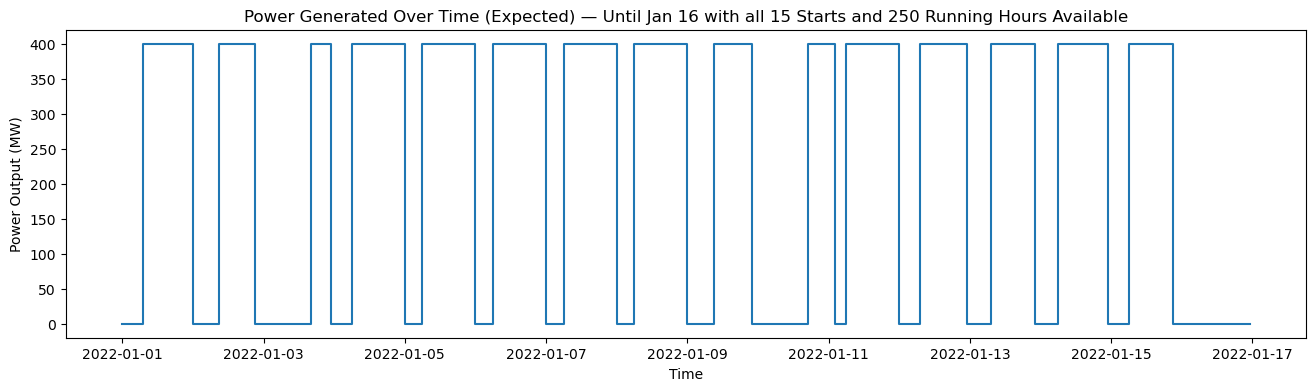

In [33]:
# schedule for earlier maintenance model until 16th januari
plt.figure(figsize=(16, 4))
plt.step(outE16th["time"], outE16th["p_mw"], where="post")
plt.title("Power Generated Over Time (Expected) — Until Jan 16 with all 15 Starts and 250 Running Hours Available")
plt.xlabel("Time")
plt.ylabel("Power Output (MW)")
plt.show()

In [ ]:
# Sensitivity analysis for the different hours and starts

In [47]:
def run_sensitivity_batch(sim_dfs, m, c, START,
                          starts_list, hours_list,
                          time_limit=3600, init_running=True,
                          scenario_weights=None):
    """
    Runs optimization for each (MAX_STARTS, MAX_RUN_HOURS) pair,
    evaluates schedule across scenarios.
    """
    rows = []

    for max_starts in starts_list:
        for max_hours in hours_list:
            model, out = optimize_ccgt_bucket_expected(
                sim_dfs,
                MAX_STARTS=max_starts,
                MAX_RUN_HOURS=max_hours,
                time_limit=time_limit,
                init_running=init_running,
                scenario_weights=scenario_weights,
                START=START
            )

            stats = evaluate_schedule_across_scenarios(
                out, sim_dfs, m, c, START,
                scenario_weights=scenario_weights
            )

            rows.append({
                "max_starts": max_starts,
                "max_run_hours": max_hours,
                "expected_profit": stats["expected_profit"],
                "std_profit": stats["std_profit"],
                "VaR_5pct": stats["VaR_5pct"],
                "CVaR_5pct": stats["CVaR_5pct"],
                "starts_used": int(out["start"].sum()) if "start" in out else int((out["start_type"] > 0).sum()),
                "hours_run": int(out["on"].sum()),
            })

    return pd.DataFrame(rows)


# fixed 15 starts, hours 250 to 253
df_hours = run_sensitivity_batch(
    sim_dfs, m, c, START,
    starts_list=[15],
    hours_list=[250, 251, 252, 253],
    time_limit=3600,
    init_running=True
)

# fixed 250 hours, starts 15 to 18
df_starts = run_sensitivity_batch(
    sim_dfs, m, c, START,
    starts_list=[15, 16, 17, 18],
    hours_list=[250],
    time_limit=3600,
    init_running=True
)

print(df_hours.sort_values(["max_starts", "max_run_hours"]))
print(df_starts.sort_values(["max_run_hours", "max_starts"]))

Status: Optimal
Objective (expected profit): 5405668.931111108
Total running hours: 250
Total starts: 15
Status: Optimal
Objective (expected profit): 5416350.851111108
Total running hours: 251
Total starts: 15
Status: Optimal
Objective (expected profit): 5427022.451111108
Total running hours: 252
Total starts: 15
Status: Optimal
Objective (expected profit): 5437056.051111109
Total running hours: 253
Total starts: 15
Status: Optimal
Objective (expected profit): 5405668.931111108
Total running hours: 250
Total starts: 15
Status: Optimal
Objective (expected profit): 5527640.920000004
Total running hours: 250
Total starts: 16
Status: Optimal
Objective (expected profit): 5595563.460000006
Total running hours: 250
Total starts: 17
Status: Optimal
Objective (expected profit): 5665407.979999997
Total running hours: 250
Total starts: 18
   max_starts  max_run_hours  expected_profit     std_profit      VaR_5pct  \
0          15            250     5.405669e+06  753804.143572  4.321223e+06   
1   

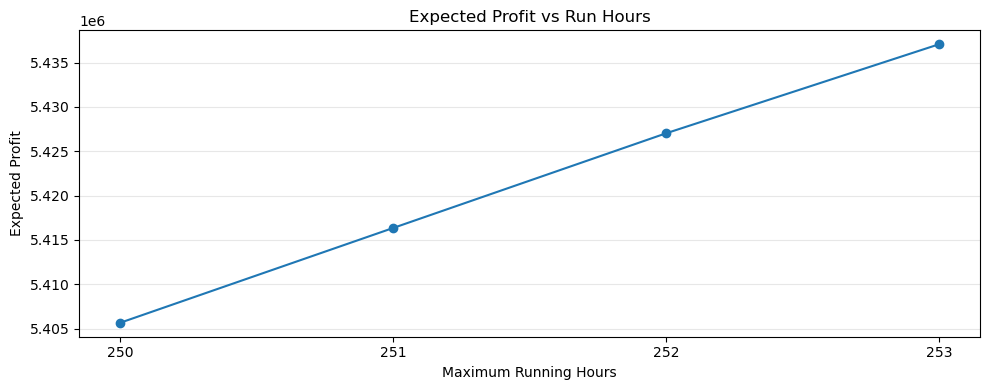

In [35]:
# plot profit vs hours
df_plot_hours = df_hours.sort_values("max_run_hours")

plt.figure(figsize=(10, 4))
plt.plot(
    df_plot_hours["max_run_hours"],
    df_plot_hours["expected_profit"],
    marker="o"
)

plt.title("Expected Profit vs Run Hours")
plt.xlabel("Maximum Running Hours")
plt.ylabel("Expected Profit")

plt.xticks(df_plot_hours["max_run_hours"])

plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

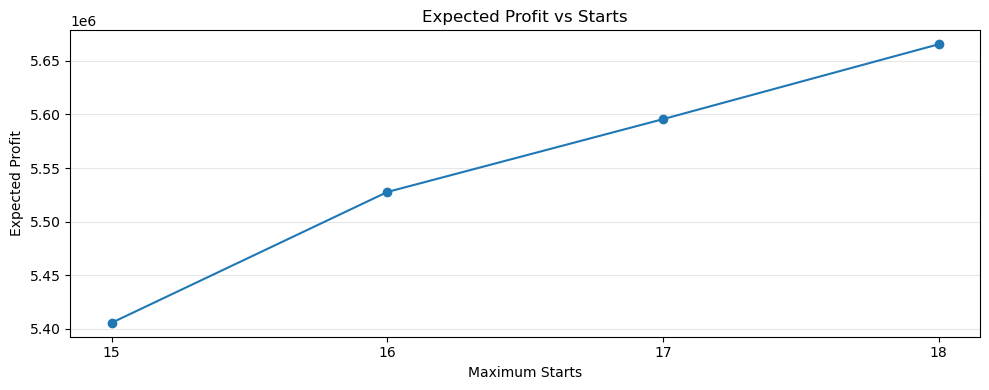

In [37]:
# plot profit vs starts
df_plot_starts = df_starts.sort_values("max_starts")

plt.figure(figsize=(10, 4))
plt.plot(
    df_plot_starts["max_starts"],
    df_plot_starts["expected_profit"],
    marker="o"
)

plt.title("Expected Profit vs Starts")
plt.xlabel("Maximum Starts")
plt.ylabel("Expected Profit")

plt.xticks(df_plot_starts["max_starts"])

plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [1]:
import dill
dill.dump_session("session.dill")

In [3]:
import os

os.path.exists("session.dill")


True

In [5]:
os.path.getsize("session.dill")


11720